# Import Modules

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\debon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\debon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\debon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Exploration

In [2]:
df = pd.read_csv("data_imdb.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
rows = df.shape[0]
print("Total number of rows:", rows)
columns = df.shape[1]
print("Total number of columns:", columns)
unique_review = df['review'].nunique()
print("Total number of unique reviews:", unique_review)
unique_sentiment_label = df['sentiment'].nunique()
print("Total number of unique sentiment labels:", unique_sentiment_label)

Total number of rows: 50000
Total number of columns: 2
Total number of unique reviews: 49581
Total number of unique sentiment labels: 2


In [4]:
#From the above results we can see that there are duplicate rows
#Removing duplicate rows
df= df.drop_duplicates(subset='review', keep='first')

In [5]:
#checking the data types
df.info()

#We can clearly see that there are no null rows in both the columns

<class 'pandas.core.frame.DataFrame'>
Index: 49581 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49581 non-null  object
 1   sentiment  49581 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
#convert the data type of review and sentiment column to str
df['review']= df['review'].astype(str)
df['sentiment']= df['sentiment'].astype(str)

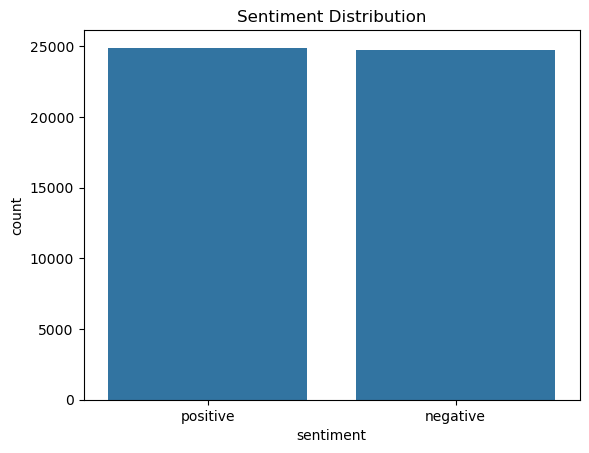

In [7]:
# Class/label distribution of sentiment column
sns.countplot(x='sentiment', data =df)
plt.title("Sentiment Distribution")
plt.show()
#this shows that the classes/labels are equally distributed and the dataset is balanced.

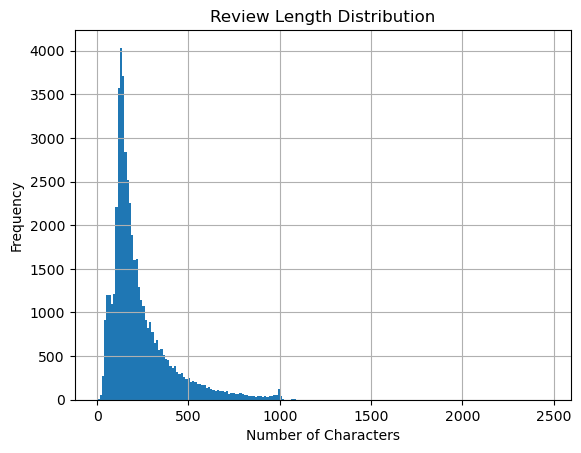

In [8]:
# Checking the length of reviews and plotting a histogram.
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].hist(bins=200)
plt.title('Review Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

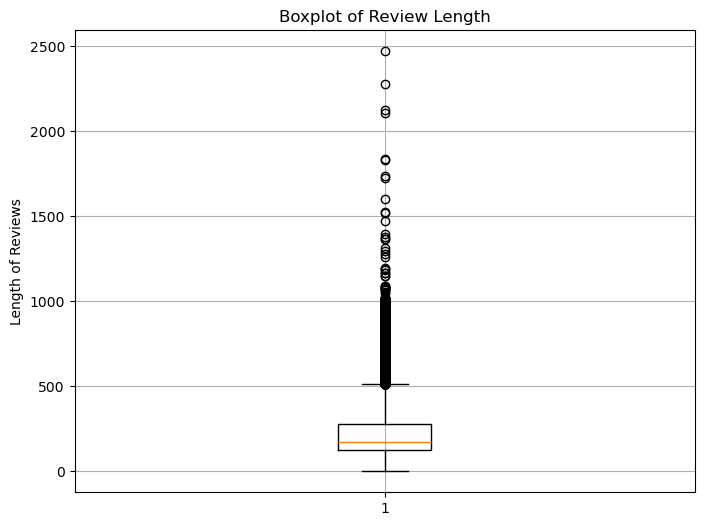

In [9]:
#find outliers by plotting box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df['review_length'])
plt.title('Boxplot of Review Length')
plt.ylabel('Length of Reviews')
plt.grid(True)
plt.show()

# This shows us that our data is right skewed with a lot of outliers beyond upper-wisker
# The median reviews are around 500-600 words per document.
# There are many review above the length of 2000 to 8000+ words.

In [10]:
# Calculating the value of upper whisker or upper bound using quartile function
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
upper_bound

513.5

In [11]:
# So as counter measure capping the number of words in review column to 514 words per document
df['review']= df['review'].apply(lambda x: " ".join(x.split()[:514]))

#### This will significantly reduce our preprocessing and model training time.

# Data Preprocessing

In [12]:
#Removing stop words, punctuation, lower-case, lemmatization and special characters.
stop_words = set(stopwords.words('english'))            #creating a varible that contains all stopwords in a set
lemmatizer = WordNetLemmatizer()                        #creating an instance of lemmatizer class
# defining a function to preprocess the above steps

def preprocess(text):
    text = re.sub(r'<.*?>', '', text)       #for removing html tags
    text = text.lower()                     #lowercase
    tokens = word_tokenize(text)            #tokenize
    filtered_words=[]
    for word in tokens:
        if word.isalpha() and word not in stop_words and len(word)>2:   #removing stopwords and special characters along with html tags
            filtered_words.append(lemmatizer.lemmatize(word))           #lemmatizing
    return ' '.join(filtered_words)

df['review']= df['review'].apply(preprocess)

In [13]:
#Looking at the quality of cleaned/preprocessed data
df['review']

0        one reviewer mentioned watching episode hooked...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movie high art fan expec...
Name: review, Length: 49581, dtype: object

# Feature Engineering

In [14]:
#Textual Features
df['word_count']= df['review'].apply(lambda x: len(x.split()))
df['Char_count']= df['review'].apply(len)
df['Avg_word_len']= df['Char_count']/df['word_count']

df[['word_count', 'Char_count','Avg_word_len']]

,word_count,Char_count,Avg_word_len
0,154,1048,6.805195
1,80,604,7.550000
2,78,535,6.858974
3,60,405,6.750000
4,117,803,6.863248
...,...,...,...
49995,76,487,6.407895
49996,52,360,6.923077
49997,112,778,6.946429
49998,112,808,7.214286


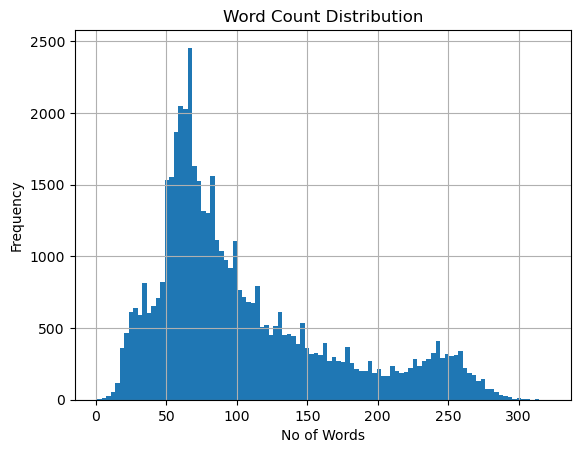

In [15]:
#Visualising the above features
df['word_count'].hist(bins=100)
plt.title("Word Count Distribution")
plt.ylabel("Frequency")
plt.xlabel("No of Words")
plt.show()

In [16]:
#Vectorization of review column
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['review']).toarray()
y = df['sentiment']

# Model Development

In [17]:
#Splitting the data set to train and test models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}:\n")
    print("Accuracy Score:", round(accuracy_score(y_test, preds)*100,2),"%")
    print("Classification Report\n",classification_report(y_test, preds))


Logistic Regression:

Accuracy Score: 88.31 %
Classification Report
               precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4995
    positive       0.87      0.90      0.88      4922

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


Naive Bayes:

Accuracy Score: 85.33 %
Classification Report
               precision    recall  f1-score   support

    negative       0.86      0.84      0.85      4995
    positive       0.84      0.87      0.85      4922

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917


SVM:

Accuracy Score: 87.61 %
Classification Report
               precision    recall  f1-score   support

    negative       0.88      0.87      0.88      4995
    positive       0.87      0.88      0.88      49

From testing of the above models we can conclude that Logistic Regression gives the best accuracy (88.31%) so we will train our final model with logistic regression and evaluate its performance furthur. Additionally SVM model is not suitable for the project as it exceeds time bound.

In [19]:
#Final development of Logistic Regression Model

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)



LogisticRegression(max_iter=1000)

# Model Evaluation

Logistic Regression
Accuracy Score: 88.31 %
Classification report
               precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4995
    positive       0.87      0.90      0.88      4922

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



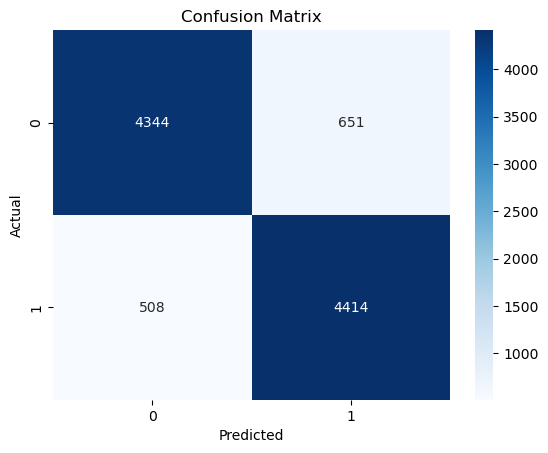

In [21]:
#Make predictions using test data
y_pred = log_reg_model.predict(X_test)

#Final model evaluation using proper evaluation metrics.
print("Logistic Regression")
print("Accuracy Score:", round(accuracy_score(y_test, y_pred)*100,2),"%")       #Accuracy Score
print("Classification report\n",classification_report(y_test, y_pred))                                    #Classification Report

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap= 'Blues')            
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion matrix detailed review: High True Positive (4411) and True Negative (4347) values indicate strong model performance on both classes. The majority of predictions are correct, suggesting good overall accuracy.